In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import utils

In [28]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [29]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL


In [30]:
test.head(2)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."


In [31]:
print("Number of labelled training examples: {}".format(train.shape[0]))

Number of labelled training examples: 19579


Distribution of training data for the three authors


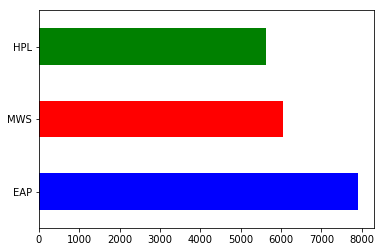

In [32]:
print("Distribution of training data for the three authors")
train['author'].value_counts().plot(kind="barh", color='brg')

In [33]:
print("Number of unlabelled test examples: {}".format(test.shape[0]))

Number of unlabelled test examples: 8392


In [34]:
# simple split for screening model performance
X_train, X_test, y_train, y_test = train_test_split(train.text, train.author, test_size=0.20, random_state=42)

In [35]:
# n-fold stratified CV for robust model performance
X = train.text
y = train.author

In [36]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [37]:
le.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [38]:
# sanity check for label ordering
# 0: EAP, 1: HPL, 2: MWS

In [39]:
y[:5]

0    EAP
1    HPL
2    EAP
3    MWS
4    HPL
Name: author, dtype: object

In [40]:
le.transform(y)[:5]

array([0, 1, 0, 2, 1])

In [41]:
def kfold_CV(clf, X, y, folds, transform=True):
    """ Run a stratified k-fold Cross Validation on the training set and print the results.
        
        Args:
            clf (Pipeline): sklearn Pipeline
            X    (pandas df): data points, here: novel snippets
            y    (pandas df): class labels, here: authors
            folds      (int): number of folds
            transform (bool): if True, use .fit_transform(); if False, use .fit()
    """

    kf = StratifiedKFold(n_splits=folds, shuffle=True)
    
    precision, recall, f1 = [], [], []

    fold_cntr = 1
    for train_index, test_index in kf.split(X,y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if transform == True:
            clf.fit_transform(X_train, y_train)
        else:
            clf.fit(X_train, y_train)
        
        predicted = text_clf.predict(X_test)
        prec_, rec_, f1_ = precision_recall_fscore_support(y_test, predicted, average='macro')[:3]
        
        precision.append(prec_)
        recall.append(rec_)
        f1.append(f1_)
        
        print("FOLD: {} Precision: {}, Recall: {}, F1: {}".format(fold_cntr, round(prec_,3), round(rec_,3), round(f1_,3)))
        fold_cntr += 1
        
    print("\nAverage results of {}-fold stratified CV\n".format(folds))
    print("Precision: {}, Standard deviation: {}".format(np.mean(precision), np.std(precision)))
    print("Recall:    {}, Standard deviation: {}".format(np.mean(recall), np.std(recall)))
    print("Macro f1:  {}, Standard deviation: {}".format(np.mean(f1), np.std(f1)))

## Logistic Regression

In [42]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LogisticRegression(C=1.0, penalty='l2', class_weight='balanced')),
])

In [43]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [44]:
text_clf.score(X_test, y_test)

0.82737487231869256

In [45]:
predicted = text_clf.predict(X_test)

In [46]:
print(classification_report(predicted, y_test))

             precision    recall  f1-score   support

        EAP       0.85      0.81      0.83      1645
        HPL       0.80      0.83      0.82      1037
        MWS       0.82      0.84      0.83      1234

avg / total       0.83      0.83      0.83      3916



In [47]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10)

FOLD: 1 Precision: 0.835, Recall: 0.828, F1: 0.831
FOLD: 2 Precision: 0.832, Recall: 0.825, F1: 0.828
FOLD: 3 Precision: 0.815, Recall: 0.81, F1: 0.812
FOLD: 4 Precision: 0.831, Recall: 0.826, F1: 0.828
FOLD: 5 Precision: 0.838, Recall: 0.834, F1: 0.835
FOLD: 6 Precision: 0.834, Recall: 0.827, F1: 0.83
FOLD: 7 Precision: 0.844, Recall: 0.836, F1: 0.839
FOLD: 8 Precision: 0.83, Recall: 0.825, F1: 0.827
FOLD: 9 Precision: 0.838, Recall: 0.831, F1: 0.834
FOLD: 10 Precision: 0.83, Recall: 0.826, F1: 0.828

Average results of 10-fold stratified CV

Precision: 0.8327202045213452, Standard deviation: 0.0071148314866154964
Recall:    0.8269225910688011, Standard deviation: 0.006698272602426866
Macro f1:  0.8293355755974892, Standard deviation: 0.006845894699023899


## Multinomial Naive Bayes

In [48]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()),
])

In [49]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [50]:
text_clf.score(X_test, y_test)

0.83375893769152198

In [51]:
predicted = text_clf.predict(X_test)

In [52]:
print(classification_report(predicted, y_test))

             precision    recall  f1-score   support

        EAP       0.82      0.84      0.83      1532
        HPL       0.81      0.85      0.83      1024
        MWS       0.87      0.81      0.84      1360

avg / total       0.83      0.83      0.83      3916



In [53]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10, transform=False)

FOLD: 1 Precision: 0.844, Recall: 0.841, F1: 0.842
FOLD: 2 Precision: 0.853, Recall: 0.854, F1: 0.853
FOLD: 3 Precision: 0.838, Recall: 0.836, F1: 0.836
FOLD: 4 Precision: 0.847, Recall: 0.849, F1: 0.848
FOLD: 5 Precision: 0.838, Recall: 0.837, F1: 0.836
FOLD: 6 Precision: 0.843, Recall: 0.84, F1: 0.841
FOLD: 7 Precision: 0.841, Recall: 0.839, F1: 0.839
FOLD: 8 Precision: 0.852, Recall: 0.85, F1: 0.851
FOLD: 9 Precision: 0.865, Recall: 0.862, F1: 0.862
FOLD: 10 Precision: 0.838, Recall: 0.838, F1: 0.837

Average results of 10-fold stratified CV

Precision: 0.8458337822067576, Standard deviation: 0.008204266770652842
Recall:    0.8447720502255471, Standard deviation: 0.008247687296600774
Macro f1:  0.8446014765667513, Standard deviation: 0.008268558137450612


In [54]:
name = "baseline_submission"

In [55]:
utils.predict_for_kaggle(clf=text_clf, X=test.text, columns=le.classes_, ids=test.id, name=name)

,EAP,HPL,MWS
id,,,
id02310,3.013316e-03,1.797291e-04,9.968070e-01
id24541,9.999947e-01,5.158223e-06,1.062187e-07
id00134,4.775989e-03,9.952202e-01,3.784022e-06
id27757,4.351039e-01,5.648960e-01,1.823274e-07
id04081,9.626553e-01,7.404530e-03,2.994018e-02
id27337,9.295024e-01,7.041833e-02,7.922729e-05
id24265,9.859088e-01,8.606992e-03,5.484237e-03
id25917,2.546009e-04,7.878901e-04,9.989575e-01
id04951,9.998365e-01,1.635120e-04,1.097967e-08


## Support Vector Machine

In [56]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', SGDClassifier()),
])

In [57]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

In [58]:
text_clf.score(X_test, y_test)

0.79111338100102147

In [59]:
predicted = text_clf.predict(X_test)

In [60]:
print(classification_report(predicted, y_test))

             precision    recall  f1-score   support

        EAP       0.80      0.80      0.80      1581
        HPL       0.73      0.84      0.78       935
        MWS       0.83      0.76      0.79      1400

avg / total       0.79      0.79      0.79      3916



In [61]:
kfold_CV(clf=text_clf, X=X, y=y, folds=10)

FOLD: 1 Precision: 0.818, Recall: 0.818, F1: 0.817
FOLD: 2 Precision: 0.821, Recall: 0.819, F1: 0.819
FOLD: 3 Precision: 0.824, Recall: 0.812, F1: 0.815
FOLD: 4 Precision: 0.807, Recall: 0.8, F1: 0.801
FOLD: 5 Precision: 0.814, Recall: 0.805, F1: 0.808
FOLD: 6 Precision: 0.795, Recall: 0.788, F1: 0.79
FOLD: 7 Precision: 0.782, Recall: 0.785, F1: 0.782
FOLD: 8 Precision: 0.808, Recall: 0.782, F1: 0.785
FOLD: 9 Precision: 0.801, Recall: 0.794, F1: 0.793
FOLD: 10 Precision: 0.817, Recall: 0.801, F1: 0.806

Average results of 10-fold stratified CV

Precision: 0.808638759330829, Standard deviation: 0.012268274253728605
Recall:    0.8003968891964384, Standard deviation: 0.012700073648492181
Macro f1:  0.8017314280632434, Standard deviation: 0.01277753724096159
